---

## Universidad de Costa Rica
### Escuela de Ingeniería Eléctrica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas

Segundo semestre del 2020

---

* Estudiante: **Karol Liseth Hernández Morera**
* Carné: **B63367**
* Grupo: **1**


# `P3` - *La demanda energética de electricidad en Costa Rica, parte II*

> Esta actividad extiende el análisis y modelado realizados anteriormente sobre la demanda eléctrica del país a partir de una base de datos del Instituto Costarricense de Electricidad del 2019. El énfasis ahora es encontrar las relaciones que existen entre los modelos de cada hora analizada.

---
* Elaboración de nota teórica y demostración: **Jeaustin Sirias Chacón**, como parte de IE0499 - Proyecto Eléctrico: *Estudio y simulación de aplicaciones de la teoría de probabilidad en la ingeniería eléctrica*.
* Revisión: **Fabián Abarca Calderón**


---
## 1. - Introducción

Ampliando el análisis del Proyecto 2, ahora hacemos referencia a un **vector aleatorio** que contiene una familia de las variables aleatorias en cuestión. Es usual expresar este hecho como:

$$
\vec{X} = (X_1, X_2, X_3, \ldots, X_n)
$$

Hablar de un conjunto multidimensional $\vec{X}$ tiene ciertas implicaciones. Cuando un vector aleatorio tiene dos variables aleatorias es posible darle una interpretación con un **sentido espacial**. Por ejemplo, supóngase que hay cierto vector aleatorio $\vec{V} = (X, Y)$ de dos dimensiones (puesto que, en efecto, hay dos variables aleatorias en $\vec{V}$). Hacer referecia ahora a un "plano" tiene sentido, en especial para evidenciar que cualquier par ordenado $(x_i, y_j)$ representa un punto aleatorio en el plano $XY$. 

Ahora bien, ¿qué ocurre cuando $\vec{V}$ es $n$-dimensional?, ¿podría ser sencillo de manipular cinco o siete dimensiones, o es siquiera posible? Este proyecto programado se abordará desde un enfoque práctico para conocer las relaciones que existen en los datos de demanda energética.

---
## 2. - La librería `fitter` para la determinación de modelos probabilísticos

Hasta el momento en el curso se han encontrado los parámetros de mejor ajuste entre un conjunto de datos (una "muestra") y un modelo probabilístico particular, quizá elegido *arbitrariamente* o por un desarrollado sentido de la intuición, del tipo: "hmm, esa distribución me parece exponencial". Sin embargo, está claro que algunos modelos hacen una mejor descripción de los datos que otros, y no siempre se puede encontrar "a puro ojo". 

En el proyecto anterior se construyó una funcion programada específicamente para hallar el modelo de mejor ajuste para una población específica de muestras, para evidenciar una aplicación práctica de las variables aleatorias. Unas pocas distribuciones eran sometidas a prueba (distribución normal, gamma, beta, Burr tipo XII, etc.) como candidatas al mejor modelo de ajuste; no obstante, el módulo `stats` de la biblioteca SciPy ofrece hasta 80 distribuciones distintas, y sería algo tedioso probarlas todas (y hasta brusco en términos del tiempo de ejecución de Python). 

Para ello la biblioteca [`fitter`](https://fitter.readthedocs.io/en/latest/) será introducida en esta ocasión. Tal cual su nombre lo indica (*ajustador*, en español), esta herramienta provee módulos dedicados a probar todas las distribuciones de `stats`, concluyendo con "la mejor" distribución y sus parámetros de ajuste del mejor modelo. Los métodos a emplear del módulo `Fitter` (*Fitter* y *fitter* hacen referencia a términos distintos) son los siguientes:

```python
from fitter import Fitter # Invocación de la clase Fitter

f = Fitter()              # Para instanciar la clase
f.fit()                   # Para evaluar las 80+ distribuciones
f.get_best()              # Para hallar el mejor modelo 
```

### 2.1. - Instalación de `fitter`

Puede verificar si la librería está instalada en su computadora revisando la lista de paquetes de Python, en la terminal

```bash
pip list
```

Si no está, se puede instalar con

```bash
pip install fitter
```

---
## 3. - Funciones auxiliares

Es útil implementar ciertas funciones que simplifiquen las asignaciones a resolver, no obstante, se observará que algunas de ellas "heredan" características e instrucciones que contenían las funciones en el anterior proyecto. 

### 3.1. - Funciones implementadas

Se contará con las siguientes funciones:

1. `extraer_datos(archivo_json, hora)`: Importa la base de datos completa y devuelve los datos de potencia a la hora indicada en un *array* de valores. Esta función es idéntica a la del proyecto anterior.

* `distribucion_conjunta(X, Y, bins)`: Pide por parámetros dos variables aleatorias, $X$ y $Y$, y el número de divisones (`bins`) en el histograma. Visualiza un histograma bivariado y retorna los datos de la función bivariada discreta en dos formatos distintos.

* `evaluar_modelos(datos)`: Encuentra la distribución de mejor ajuste y retorna los parámetros del modelo correspondiente para la muestra en `datos`.

* `densidad_marginal()`: 

* `energia_diaria(archivo_json)`: Importa la base de datos completa en formato **JSON** y calcula la energía diaria usando [la regla del trapecio](https://es.wikipedia.org/wiki/Regla_del_trapecio) y retorna un vector con muestras diarias de energía.

* `parametros_energia(vector_energia)`: Recibe por parámetro un vector de energía diaria y retorna la media y la desviación estándar basadas en las muestras ingresadas.

Las llamadas a bibliotecas de Python de interés para este proyecto programado son:

```python
# Para manipular datos de interés y calcular resultados
import numpy as np 

# Para evaluar el modelo de mejor ajuste en una población
from fitter import Fitter 

# Para manipular y leer la base de datos de demanda
import pandas as pd  

# La música de la fiesta
from scipy import stats    

# Para visualizar resultados relevantes
import matplotlib.pyplot as plt  

# Para manipulación de formatos temporales
from datetime import datetime    
```

#### 3.1.1. - Importación y acondicionamiento con `extraer_datos`

In [93]:
import pandas as pd
import numpy as np
from datetime import datetime

def extraer_datos(archivo_json, hora):
    '''Importa la base de datos completa y devuelve los
    datos de potencia a la hora indicada en un
    array de valores.
    '''
    
    # Cargar el "DataFrame"
    df = pd.read_json(archivo_json) 
    
    # Convertir en un array de NumPy
    datos = np.array(df)                

    # Crear vector con los valores demanda en una hora
    demanda = []

    # Extraer la demanda en la hora seleccionada
    for i in range(len(datos)):
        instante = datetime.fromisoformat(datos[i][0]['fechaHora'])
        if instante.hour == hora:
            demanda.append(datos[i][0]['MW'])

    return demanda

#### 3.1.2. - Parámetros y modelos de mejor ajuste con `distribucion_conjunta`

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def distribucion_conjunta(X, Y, bins):
    '''Pide por parámetros dos variables aleatorias
    X y Y, así como el número de 'bins' o divisiones
    a emplear para construir el histograma bivariado.
    Crea una gráfica y retorna dos tablas de datos de
    pares ordenados x, y y su probabilidad p asociada.
    '''
    np.seterr(all='ignore') # ignorar advertencias
    
    # Se inicializa la figura interactiva 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Se obtiene el plano de probabilidades para graficar el hist3D
    hist, xbins, ybins = np.histogram2d(X, Y, bins=bins, normed=False)
    hist = hist / sum(sum(hist))
    xbins = (xbins + np.roll(xbins, -1))[:-1] / 2.0 
    ybins = (ybins + np.roll(ybins, -1))[:-1] / 2.0 
    
    #Formatos de retorno para la funcion de densidad bivariada discreta
    xyp = [[xbins[i], ybins[j], hist[i][j]] for i in range(bins) for j in range(bins)]
    xy = hist 

    # Se construyen los arreglos para el ancho de Bins * Bins barras
    xpos, ypos = np.meshgrid(xbins, ybins, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Se dimensiona el ancho visual de las barras (como un sólido).
    dx = dy = 30 * np.ones_like(zpos)
    dz = hist.ravel() 

    # Se visualiza el histograma 3D
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
    ax.set_xlabel('La hora 1, $X$')
    ax.set_ylabel('La hora 2, $Y$')
    ax.set_zlabel('Probabilidad')
    plt.show()

    return xyp, xy, xbins, ybins
    

Obsérvese que la función anterior retorna los datos de la función bivariada sobre la base de las variables aleatorias $X$ y $Y$ en dos arreglos distintos `xyp` y `xy` con el objetivo de simplificar la manipulación de datos en las actividades por realizar. Lucen de la siguiente forma:

**El formato `xyp`**

```python
    x   y      P
0  x1  y1  0.001
1  x1  y2  0.020
2  x1  y3  0.092
3  x2  y1  0.093
4  x2  y2  0.083
.   .   .    .
n   xn  yn   Pn
```

**El formato `xy`**

```python
      y1      y2      y3      y4    .   yn
x1  0.030  0.0400  0.0400  0.0400   .    .
x2  0.090  0.0056  0.0400  0.0860   .    .
x3  0.005  0.0450  0.0690  0.0010   .    .
x4  0.060  0.0230  0.0025  0.0014   .    .
.     .       .       .       .     .    .
xn    .       .       .       .     .    .
```

En ambos casos, independientemente, se puede interpretar los elementos $x_n$ y $y_n$ (las variables `xbins` y `ybins`) como los puntos medios de las divisiones por dimensión (`bins`). Para este caso ambas dimensiones tendrán siempre la misma cantidad de divisiones, por la forma en que ha programado la función `distribucion_conjunta`.

#### 3.1.3. - Determinación del modelo de mejor ajuste con `evaluar_modelos`

In [95]:
from fitter import Fitter

def evaluar_modelos(datos):
    '''Evalúa las 80 distribuciones del módulo stats
    y obtiene el el modelo de mejor ajuste para
    la demanda anual de una hora específica. Retorna
    el nombre de la mejor distribución y una tupla con
    los parámetros del modelo.
    '''
    
    np.seterr(all='ignore') # ignorar advertencias
    
    # Hallar el mejor ajuste con Fitter
    f = Fitter(datos, timeout=120)
    f.fit()
    ajuste = f.get_best()
    
    for i in ajuste.keys():
        dist, params = i, ajuste[i]

    print('------------\nDistribución\n------------')
    print(dist, '\n')
    print('----------\nParámetros\n----------')
    print(params)

    return dist, params

#### 3.1.4. - Comparación de la densidad marginal y un modelo con `densidad_marginal`

In [96]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def densidad_marginal(xy, bins, dist, params, eje):
    '''Se elige eje='x' o eje='y' según sea el caso para la 
    densidad marginal en Y o en X. El parámetro 'xy' es la
    tabla de datos, 'bins' es el vector de valores de potencia 
    xbins o ybins. Los parámetros 'dist' y 'params' corresponden
    al modelo de mejor ajuste retornado por el fitter.
    '''
    
    np.seterr(all='ignore') # ignorar advertencias
    
    # Hallar la densidad marginal de X o Y, según se indique en 'eje'
    if eje == 'x':
        filas = len(xy)
        marginal = [sum(xy[i]) for i in range(filas)]
    elif eje == 'y':
        xy = xy.transpose()
        filas = len(xy)
        marginal = [sum(xy[i]) for i in range(filas)]

    # Visualizar modelo de mejor ajuste
    distro = getattr(stats, dist) 
    d = np.arange(min(bins)*0.96, max(bins)*1.04, 1)
    pdf_plot = distro.pdf(d, *params)
    plt.plot(d, pdf_plot*22, lw=3.5, color='r')
    
    # Visualizar función de densidad marginal
    plt.bar(bins, marginal, width=12)
    plt.title('Contraste: densidad marginal vs. modelo de mejor ajuste')
    plt.xlabel('Potencia [MW]')
    plt.ylabel('Densidad Probabilística')
    plt.show()
    
    return marginal

#### 3.1.5. - Calculando el consumo diario y parámetros relevantes con `energia_diaria`

In [97]:
import pandas as pd
import numpy as np
from datetime import datetime

def energia_diaria(archivo_json):
    '''Importa la base de datos completa y devuelve
    un vector con la energía diaria, en MWh.
    '''
    
    # Cargar el "DataFrame"
    df = pd.read_json(archivo_json) 

    # Convertir en un array de NumPy
    datos = np.array(df)  

    # Crear vector con todos los valores horarios de demanda
    demanda = []

    # Extraer la magnitud de la demanda para todas las horas
    for hora in range(len(datos)):
        instante = datetime.fromisoformat(datos[hora][0]['fechaHora'])
        demanda.append(datos[hora][0]['MW'])

    # Separar las magnitudes en grupos de 24 (24 h)
    demanda = np.split(np.array(demanda), len(demanda) / 24)

    # Crear vector para almacenar la enegia a partir de la demanda
    energia = []

    # Calcular la energia diaria por la regla del trapecio
    for dia in range(len(demanda)):
        E = round(np.trapz(demanda[dia]), 2)
        energia.append(E)

    return energia


#### 3.1.6. - Determinación de parámetros del consumo diario con `parametros_energia`

In [98]:
import numpy as np

def parametros_energia(vector_energia):
    '''Calcula los parámetros media y desviación
    estándar en el vector de energía
    '''

    media = np.median(vector_energia)
    desviacion = np.std(vector_energia)

    return media, desviacion

### 3.2. - Probando las funciones implementadas

Ahora bien, se puede elaborar una breve demostración práctica basada en las funciones anteriormente implementadas, haciendo sus respectivas llamadas:

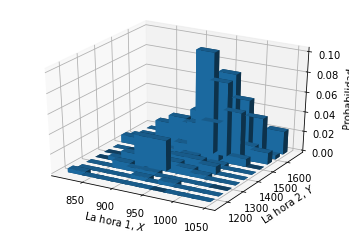

In [99]:
# Se eligen las dos horas que desean estudiarse
hora_1 = extraer_datos('demanda_2019.json', 3) 
hora_2 = extraer_datos('demanda_2019.json', 11) 

# Se ejecuta el análisis bivariado
xyp, xy, xbins, ybins = distribucion_conjunta(hora_1, hora_2, bins = 10)

In [100]:
# Se llama obtiene los parámetros de mejor ajuste para cada hora
dist, params = evaluar_modelos(hora_1)

# Nota: esta función es de más lenta ejecución

C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


------------
Distribución
------------
genlogistic 

----------
Parámetros
----------
(0.6318766353534495, 952.2292025622228, 19.795927564550382)


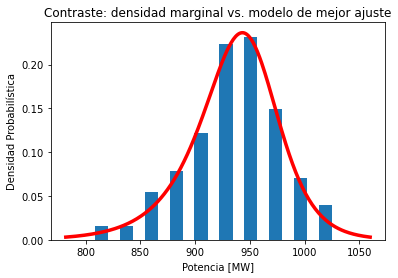

[0.01568627450980392,
 0.01568627450980392,
 0.054901960784313725,
 0.0784313725490196,
 0.12156862745098039,
 0.2235294117647059,
 0.23137254901960785,
 0.14901960784313723,
 0.07058823529411765,
 0.0392156862745098]

In [101]:
# Se contrasta la densidad marginal para cada hora, según su eje
densidad_marginal(xy, xbins, dist, params, eje='x')

---
## 4. - Asignaciones del proyecto

El análisis se hará sobre dos horas distintas del día, elegidas de forma aleatoria. 

**Asignación de horas**

La siguiente función utiliza los dígitos numéricos del carné de cada estudiante para asignar las horas con las que se construirán la variables aleatoria $X$ y la variable aleatoria $Y$. 

**Ejemplo**: el carné B12345 utiliza los dígitos 12345 y obtiene las horas 19 y 7.

In [102]:
import random

def horas_asignadas(digitos):
    '''Elige una hora A en periodo punta
    y una hora B de los otros periodos,
    con los dígitos del carné como "seed"
    '''
    
    random.seed(digitos)
    punta = [11, 12, 18, 19, 20]
    valle = [7, 8, 9, 10, 13, 14, 15, 16, 17]
    nocturno = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6]
    otro = valle + nocturno
    HX = punta[random.randrange(0, len(punta))]
    HY = otro[random.randrange(0, len(otro))]
    horas = 'Hora X: {}, hora Y: {}'.format(HX, HY)
    return horas

In [103]:
mis_horas = horas_asignadas(63367)
print(mis_horas)

# Bonus: los "docstrings" y la función help()
help(horas_asignadas)

Hora X: 12, hora Y: 9
Help on function horas_asignadas in module __main__:

horas_asignadas(digitos)
    Elige una hora A en periodo punta
    y una hora B de los otros periodos,
    con los dígitos del carné como "seed"



### 4.1. - Función distribución múltiple bivariada

Es posible analizar una variable aleatoria en relación con otra. Para empezar, se puede visualizar su comportamiento "conjunto".

* (10%) Visualice los datos de la variable aleatoria múltiple a las dos horas elegidas, en la forma de un histograma conjunto.
* (15%) Determine las funciones de densidad marginales $f_X(x)$ y $f_Y(y)$ a partir de los datos y utilizando un modelo de mejor ajuste.
* (10%) Determine los valores esperados $E[X]$ y $E[Y]$ de los datos.

En este proyecto no deduciremos la *función de densidad conjunta*, que en general necesita de otros métodos numéricos para encontrar una expresión algebraica.

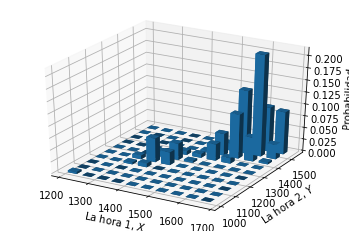

C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4522: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


------------
Distribución
------------
johnsonsu 

----------
Parámetros
----------
(1.7130748784740093, 1.3492318786794109, 1644.3259347008984, 46.32082763663503)


C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4522: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


------------
Distribución
------------
foldcauchy 

----------
Parámetros
----------
(39.90076470238408, -0.20752995983048114, 36.27042598807426)


C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4522: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


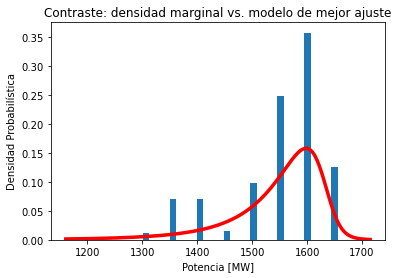

C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4522: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


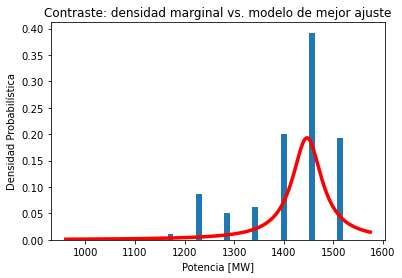

Consumo energético promedio para las 12 p.m: 1545.0704 MWh 

Consumo energético promedio para las 9 a.m: 1415.9760 MWh 



In [104]:
# 4.1. - Función distribución múltiple bivariada

#----------------------- Parte 4.1.1 ------------------------------------------------------

# Se eligen las dos horas que desean estudiarse
hora_1 = extraer_datos('demanda_2019.json', 12) 
hora_2 = extraer_datos('demanda_2019.json', 9) 

# Se ejecuta el análisis bivariado para la  visualización de las variables múltiples de las dos horas

xyp, xy, xbins, ybins = distribucion_conjunta(hora_1, hora_2, bins = 10)

#----------------------- Parte 4.1.2 ------------------------------------------------------

# Se llama obtiene los parámetros de mejor ajuste para cada hora

dist, params = evaluar_modelos(hora_1)    # Parámetros para la hora_1 (12p.m)  

dist2, params2 = evaluar_modelos(hora_2)  # Parámetros para la hora_2 (9 a.m)  

# Se contrasta la densidad marginal para cada hora, según su eje

densidad_marginal(xy, xbins, dist, params, eje='x')

densidad_marginal(xy, ybins, dist2, params2, eje='y')


#----------------------- Parte 4.1.3 ------------------------------------------------------

# La media para la hora 1 (12 p.m)  

EX_h1 = np.mean(hora_1)
print('Consumo energético promedio para las 12 p.m: {:0.4f}'.format(EX_h1) ,"MWh", "\n")


# La media para la hora 2 (9 a.m)

EY_h2 = np.mean(hora_2)
print('Consumo energético promedio para las 9 a.m: {:0.4f}'.format(EY_h2) ,"MWh", "\n")



### 4.2. - Correlación entre el consumo a distintas horas del día

¿Un alto consumo de potencia a la hora $X$ está correlacionado con un alto consumo de potencia a la hora $Y$ del mismo día? Esta pregunta puede abordarse con las métricas de correlación y covarianza entre dos variables aleatorias.

* (15%) Calcule la correlación entre $X$ y $Y$, $E[XY] = R_{XY}$. Para esto, puede utilizar los datos provistos y la versión discreta de la fórmula de correlación, dada por $$\begin{aligned} R_{XY} = m_{11} & = E[XY] \\ & = \sum_{x=-\infty}^{\infty} \sum_{y=-\infty}^{\infty} x y ~ p(x, y) \end{aligned}$$ donde $p(x, y)$ son las probabilidades asociadas a cada par $(x, y)$.
* (10%) ¿Están correlacionadas estas variables? Recordar que la prueba de correlación es $E[XY] = E[X]E[Y]$ (puede aplicar una tolerancia del 5%).
* (10%) Determine la covarianza y el índice de correlación de Pearson.
* (10%) Análisis: ¿qué implica este valor del índice de correlación de Pearson?

In [105]:
# 4.2. - Correlación entre el consumo a distintas horas del día

#----------------- Parte 4.2.1 --------------------------------------------------

# Dado que la 𝑅𝑋𝑌 = 𝑚11= 𝐸[𝑋𝑌], la sumatoria implica que se de Xn*Yn*p(x,y), se procede a obtener las variables:  

R_xy= 0        # Variable para obtener los valores de R_xy
vx_n=[]        # Vector para los valores Xn
vy_n= []       # Vector para los valores Yn
for i in xyp:   
    R_xy+= i[0]*i[1]*i[2]   # Xn*Yn*p(x,y) para cada fila de la matriz xyp
    vx_n.append(i[0])       # Se agregan los valores de Xn a la tupla vx_n
    vy_n.append(i[1])       # Se agregan los valores de Yn a la tupla vy_n

print('La correlación entre 𝑋 y 𝑌, 𝐸[𝑋𝑌]= 𝑅𝑋𝑌 es: {:0.4f}'.format (R_xy) ,"\n")

#----------------- Parte 4.2.2--------------------------------------------------

#  𝐸[𝑋𝑌]= 𝐸[𝑋]𝐸[𝑌]  

E_XY = EY_h2 *EX_h1 #Se realiza la ecuación anterior para realizar el cálculo 

# Valor de E[XY] = E[X]E[Y]

print('El valor E[XY] es: {:0.4f}'.format(E_XY), "\n")

Tol= abs(((R_xy)-E_XY)/(R_xy))*100

print('Tolerancia de la prueba de correlación es de: {:0.4f}'.format(Tol) , "%" "\n")


#----------------- Parte 4.2.3 --------------------------------------------------

#COVARIANZA
#Se sabe que RXY= E[XY].
# Si RXY = E[X]E[Y] no están correlacionadas. Si RXY=0 son ortogonales

C_xy = R_xy - E_XY  # Fórmula para calcular la covarianza a partir de los valores anteriormente obtenidos

print('La covarianza es de: {:0.4f}'.format(C_xy), "\n")  

# Cálculo de la desviación para los valores de Xn y Yn

desviacionH_1= np.std(vx_n)

desviacionH_2= np.std(vy_n)

# Índice de correlación de Pearson

pear =C_xy/(desviacionH_1*desviacionH_2) # Ecuación para obtener el valor del índice de Pearson

print('El índice de correlación de Pearson tiene un valor de: {:0.4f}'.format(pear), "\n")


La correlación entre 𝑋 y 𝑌, 𝐸[𝑋𝑌]= 𝑅𝑋𝑌 es: 2197011.0096 

El valor E[XY] es: 2187782.7097 

Tolerancia de la prueba de correlación es de: 0.4200 %

La covarianza es de: 9228.2999 

El índice de correlación de Pearson tiene un valor de: 0.4004 




#### -------------------------------------- Parte 4.2.4 --------------------------------------------------

El coeficiente de correlación de Pearson corresponde a una medida de correspondencia o relación lineal entre dos variables cuantitativas aleatorias, es decir, un índice empleado para medir el grado de relación que tienen las dos variables, involucradas. 
El valor del coeficiente indica como se comportan los sucesos respecto a las dos variables, entre más relación tengan, más
cercano debe ser el valor a 1. Los valores están en un intervalo entre 0 y 1, o sino -1, según el dato obtenido (0.4004) hay una correlación positiva, esto quiere decir que las dos variables se correlacionan en un sentido directo. Sin embargo, índice en este caso demuestra que no posee una relación muy alta entre las variables aleatorias, pero si existe una correspondencia aceptable.


### 4.3. - Análisis de consumo de energía semanal

Semana a semana hay un consumo total de **energía** en el país. Este valor cambia aleatoriamente, pero, ¿será posible modelar su distribución de probabilidad? Más aún, ¿es posible predecir su distribución utilizando el teorema del limíte central y el conocimiento del consumo *diario* de energía?

Si el consumo de energía de *cada día de la semana* es una variable aleatoria $E_L, E_K, \ldots, E_D$, entonces el consumo total semanal está dado por:

$$
S_E = E_L + E_K + E_M + E_J + E_V + E_S + E_D
$$

El teorema del límite central para la suma, en la versión estudiada, aplica para la suma de variables aleatorias **iid** (*independientes e idénticamente distribuidas*). Esta suposición **no** aplica para los datos estudiados dado que, por ejemplo, el consumo del lunes no es el mismo que el del domingo. Sin embargo, se hará la aproximación con unos parámetros únicos $\mu$ (la media) y $\sigma$ (la desviación estándar) para la energía consumida durante todos los días del año.

Conocidos estos parámetros y considerando "razonablemente grande" la cantidad de elementos en la suma $N = 7$, el teorema establece que

$$
Z = \frac{S_E - \mu_{S_E}}{\sigma_{S_E}} = \frac{S_N - N\mu}{\sigma \sqrt{N}}
$$

tendrá una distribución $Z \sim \mathcal{N}(0, 1)$, es decir, normal estandarizada.

* (20 %) Evalúe la hipótesis descrita. Comente los resultados.

Para esto puede crear un histograma con los resultados del consumo de energía *semanal*. Puede además calcular los parámetros $\mu$ (la media) y $\sigma$ (la desviación estándar) de la energía diaria consumida y estimar la distribución de $S_E$.

Media de la energía diaria consumida es de:30025.1449  

Desviación estándar de la energía diaria consumida es de: 1765.1915 

Valores de energía por semana : [196639.91, 205098.05, 207571.61000000002, 211580.34, 211151.75, 211033.33000000002, 216684.22999999995, 215959.83, 210868.72, 214254.36, 217155.32, 216131.03999999998, 217819.94999999995, 217655.0, 217173.68, 197143.05000000005, 219742.43000000002, 217754.75, 215779.16, 213103.41999999998, 207394.19, 207773.81999999998, 211003.59, 208934.3, 214083.45, 207153.25000000003, 206916.72999999998, 204680.6, 209445.83, 203739.86000000002, 207134.22999999998, 208136.80000000002, 197783.1, 207513.27000000002, 208357.68000000002, 205188.79] 

El valor de la distribución Z es de: -0.1707


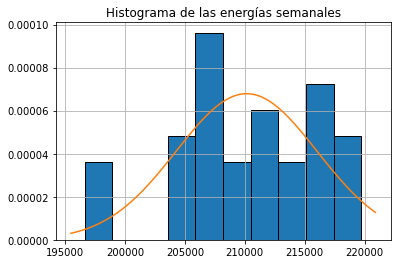

C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4522: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
C:\Users\Admin\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4522: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


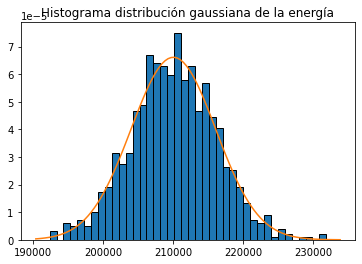

Media de la distribución gaussiana:  210037.22783566607


In [118]:
# 4.3. - Análisis de consumo de energía semanal

import math 

# Se extraen los valores de la energía 
energias= energia_diaria('demanda_2019.json')

#---------------------------------------------------------------------------------------------------------------

# 𝜇  (la media) del consumo diario
med= np.mean(energias)
print("Media de la energía diaria consumida es de:{:0.4f} ".format( med),"\n")

#---------------------------------------------------------------------------------------------------------------

# 𝜎 (la desviación estándar) del consumo diario
desv= np.std(energias)
print("Desviación estándar de la energía diaria consumida es de: {:0.4f}".format(desv),"\n")

#---------------------------------------------------------------------------------------------------------------

# Se obtiene la energía de cada semana, durante 36 semanas (252 días).

L=0 
D=7

Esemanal =[]
for i in range(36):
    
    Esemanal.append(sum(energias[L:D]))
    L+=7
    D+=7

print("Valores de energía por semana :", Esemanal,"\n")

#---------------------------------------------------------------------------------------------------------------
    
# Se obtiene la distribución Z para cada semana

d_Z =[]
N=7
for z in Esemanal:
    d_Z.append((z-N*med)/(desv*math.sqrt(N))) # (𝑆𝑁−𝑁𝜇) / 𝜎𝑁
    
Ztotal = sum(d_Z)   

print("El valor de la distribución Z es de: {:0.4f}".format(Ztotal))
 
#---------------------------------------------------------------------------------------------------------------

# Histograma de las energias semanales

from scipy.stats import norm
import matplotlib.pyplot as plt

plt.title('Histograma de las energías semanales')
med, desv=norm.fit(Esemanal)
plt.hist(Esemanal, edgecolor = 'black',density = True  )
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, med, desv)
plt.plot(x, y)
plt.grid()
plt.show()
plt.clf()

# Histograma de las energias semanales para la distribución gaussiana

loc=med
scale = desv
alea= np.random.normal(loc, scale , size=1000)
mean,std=norm.fit(alea)
plt.title('Histograma distribución gaussiana de la energía')
plt.hist(alea, edgecolor = 'black', bins=40, density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()

media= np.mean(alea)


print("Media de la distribución gaussiana: ",media)

#### -------------------------------------- Parte 4.3 --------------------------------------------------
Se observa en el histograma de la distribución gaussiana correspondiente a la $normal$ (dado que es la que presenta la distribución Z), de acuerdo a esta la media está alrededor de 210.000, conforme la hipótesis que se asumió, de que sí se puede determinar el comportamiento del consumo, mediante una distribución, se puede afirmar que es correcta, puesto que se puede observar que los resultados coinciden si se saca la media por semana $(30025.1449*7= 210176,0143)$ de los datos ya proporcionados por el ICE, si se toman como parámetros para una con valores aleatorios el comportamiento de la media es muy similar $(210037.2278)$, tomando en cuenta la aleatoriedad de las variables de acuerdo a la energía consumida cotidianamente.



---

### Universidad de Costa Rica
#### Facultad de Ingeniería
##### Escuela de Ingeniería Eléctrica

---